## Optimization probelm: 

**Description**:the goal is to fin optimal parameters for a model which describes the shape of solar cycles, minimizing the difference between observed sunspot data and the model predections. 

The **objective function**: measures how good the model fits the observed sunspot data. Here defined with **Mean Squared Error (MSE)**:

\[
\text{MSE} = \frac{1}{N} \sum_{i=1}^N \left( y_i - x(t_i) \right)^2
\]

where:
- \(N\): Number of data points (~40,000).
- \(y_i\): Observed sunspot number at time \(t_i\).
- \(x(t_i)\): Model-predicted value at time \(t_i\).

---

**Model:** the shape of  solar cycles using a mathematical function. Each solar cycle \(k\) is characterized by three parameters:
1. \(T_{0k}\): Initial time of the cycle.
2. \(T_{sk}\): Rising time of the cycle.
3. \(T_{dk}\): Declining time of the cycle.

The total model for 10 solar cycles is:

\[
x(t) = \sum_{k=1}^{10} x_k(t)
\]

where \(x_k(t)\) represents the contribution of the \(k\)-th solar cycle based on its parameters.

This results in **30 parameters to optimize** (\(T_{01}, T_{s1}, T_{d1}, \dots, T_{010}, T_{s10}, T_{d10}\)).

---
The optimization is carried out using **Simulated Annealing (SA)**:

The **Simulated Annealing (SA)** algorithm has two key hyperparameters:
1. \(T_0\): Initial temperature of the SA process, which controls the extent of exploration early in the optimization.
2. \(\sigma\): Standard deviation used in the proposal distribution for parameter updates, affecting the step sizes during exploration.

---

### Problem Variables (to be Optimized)
The **problem variables** are the 30 parameters of the model:
- \(T_{0k}\): Initial time for each cycle.
- \(T_{sk}\): Rising time for each cycle.
- \(T_{dk}\): Declining time for each cycle.

---

### Constraints:


### Limitations:


---

### Initial Solution (Non-Parallel)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import math
import os
import sys
import csv
import time


---
Load data
---

In [2]:
data = pd.read_csv("data_OptiMinds.csv")  
print(data.head())

          Time         SN
0  1754.986393   9.225870
1  1754.989171   5.921549
2  1754.991949   8.049531
3  1754.994726  14.136753
4  1754.997504   4.260318


In [3]:
# Convert fractional years to datetime to understand the data better
def fractional_year_to_date(year):
    year_int = int(year)
    remainder = year - year_int
    start_of_year = datetime.datetime(year_int, 1, 1)
    days_in_year = (datetime.datetime(year_int + 1, 1, 1) - start_of_year).days
    return start_of_year + datetime.timedelta(days=remainder * days_in_year)

# Apply conversion
data['Date'] = data['Time'].apply(fractional_year_to_date)

# Drop the original 'Time' column if not needed
#data.drop(columns=['Time'], inplace=True)

print(data.head())

          Time         SN                       Date
0  1754.986393   9.225870 1754-12-27 00:48:16.925537
1  1754.989171   5.921549 1754-12-28 01:08:16.170824
2  1754.991949   8.049531 1754-12-29 01:28:15.416110
3  1754.994726  14.136753 1754-12-30 01:48:14.661411
4  1754.997504   4.260318 1754-12-31 02:08:13.906698


--> Data collected every 20 min from 27th December 1754. 

In [4]:
data.shape

(40560, 3)

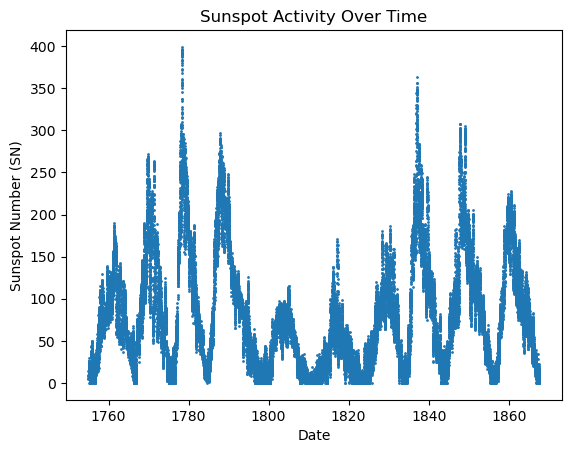

In [5]:
plt.scatter(data['Date'], data['SN'], s=1)
plt.xlabel("Date")
plt.ylabel("Sunspot Number (SN)")
plt.title("Sunspot Activity Over Time")
plt.show()

### Thinning to save ressources

In [6]:
### Get the small subset to test functions locally
subset_random = data.sample(n=1000, random_state=42)
print(subset_random.head())

              Time          SN                       Date
3318   1764.202980   61.059679 1764-03-15 06:58:50.319951
32638  1845.646723   43.003447 1845-08-25 01:17:44.775877
27227  1830.616297   82.596295 1830-08-13 22:45:48.499199
24615  1823.360804    0.000000 1823-05-12 16:38:39.795686
29045  1835.666254  132.597282 1835-09-01 04:22:56.440623


# Solar Cycle Model
def solar_cycle_model(t, params, num_cycles=10):
    """
    Models the solar cycles based on the given parameters.
    
    Args:
        t (ndarray): Array of time points.
        params (ndarray): Array of 3*num_cycles parameters 
                          [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        num_cycles (int): Number of solar cycles (default is 10).
     
    Returns:
        ndarray: Predicted values of x(t).
    """
    predicted_values = np.zeros_like(t)

    for k in range(num_cycles):
        T0 = params[3 * k]       # Start time of cycle k
        Ts = params[3 * k + 1]   # Rising time of cycle k
        Td = params[3 * k + 2]   # Declining time of cycle k

        # Compute the contribution of cycle k
        x_k = ((t - T0) / Ts) ** 2 * np.exp(-((t - T0) / Td) ** 2)

        # Set contributions to zero outside the valid range
        x_k[(t < T0) | (t > T0 + Ts + Td)] = 0
        predicted_values += x_k

    return predicted_values

# Loss Function: Mean Squared Error
def mse(params, t, observed_values):
    """
    Computes the Mean Squared Error (MSE) between observed data and model predictions.
    
    Args:
        params (ndarray): Model parameters [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        t (ndarray): Time points of the observations.
        observed_values (ndarray): Observed sunspot data.
    
    Returns:
        float: The MSE value.
    """
    predicted_values = solar_cycle_model(t, params)
    return np.mean((observed_values - predicted_values) ** 2)

# Simulated Annealing Optimization
def simulated_annealing(x0, T0, sigma, f, n_iter=2.5e5, burn_in=2e5):
    """
    Performs Simulated Annealing to optimize a given function.
    
    Args:
        x0 (ndarray): Initial parameter guess.
        T0 (float): Initial temperature.
        sigma (float): Standard deviation for the proposal distribution.
        f (function): Function to minimize.
        n_iter (int): Total number of iterations (default is 250,000).
        burn_in (int): Burn-in period (default is 200,000).
    
    Returns:
        ndarray: Array of sampled parameter values after burn-in.
    """
    x = x0.copy()  # Initialize x
    T = T0         # Initialize temperature
    n_params = x0.shape[0]  # Number of parameters to be optimized

    # Mean and covariance matrix for the jump distribution
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))
    
    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1
        x_old = x
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        
        # Compute loss difference
        DeltaE = f(x_proposal) - f(x_old)
        
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter / n_iter)
        
        # Print progress
        if iter_counter % 10000 == 0:
            print(f"Iteration {iter_counter}, Temperature: {T:.6f}, Loss: {f(x):.6f}")
        
        # Store parameters after burn-in
        if iter_counter > burn_in:
            v[iter_counter - int(burn_in) - 1, :] = x
    
    return v

# Example Usage
if __name__ == "__main__":
    # Generate synthetic data
    np.random.seed(42)
    time_points = subset_random['Time']  # Time points
    observed_values = subset_random['SN']  # Example observed sunspot data

    # Initial parameter guess
    x0 = np.random.uniform(0, 50, size=30)  # 30 parameters: [T0_1, Ts_1, Td_1, ..., T0_10, Ts_10, Td_10]

    # Simulated Annealing parameters
    T0 = 1.0  # Initial temperature
    sigma = 1.0  # Proposal standard deviation

    # Function to minimize
    def loss_function(params):
        return mse(params, time_points, observed_values)

    # Optimize parameters
    optimized_params = simulated_annealing(x0, T0, sigma, loss_function, n_iter=100000, burn_in=50000)

    # Predicted values with optimized parameters
    final_params = optimized_params[-1]
    optimized_values = solar_cycle_model(time_points, final_params)

    # Plot observed vs. optimized model
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, observed_values, label="Observed Values")
    plt.plot(time_points, optimized_values, label="Optimized Model", linestyle="--")
    plt.legend()
    plt.title("Observed vs. Optimized Model")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.show()

    # Plot parameter convergence
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(optimized_params)), [mse(p, time_points, observed_values) for p in optimized_params])
    plt.title("MSE During Optimization")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.show()


### Model function

In [7]:
# Solar Cycle Model
def solar_cycle_model(t, params, num_cycles=10):
    """
    Models the solar cycles based on the given parameters.
    
    Args:
        t (ndarray): Array of time points.
        params (ndarray): Array of 3*num_cycles parameters 
                          [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        num_cycles (int): Number of solar cycles (default is 10).
     
    Returns:
        ndarray: Predicted values of x(t).
    """
    predicted_values = np.zeros_like(t)

    for k in range(num_cycles):
        T0 = params[3 * k]       # Start time of cycle k
        Ts = params[3 * k + 1]   # Rising time of cycle k
        Td = params[3 * k + 2]   # Declining time of cycle k

        # Compute the contribution of cycle k
        x_k = ((t - T0) / Ts) ** 2 * np.exp(-((t - T0) / Td) ** 2)

        # Set contributions to zero outside the valid range
        x_k[(t < T0) | (t > T0 + Ts + Td)] = 0
        predicted_values += x_k

    return predicted_values

### Loss function (mse)

In [8]:
# Loss Function: Mean Squared Error
def mse(params, t, observed_values):
    """
    Computes the Mean Squared Error (MSE) between observed data and model predictions.
    
    Args:
        params (ndarray): Model parameters [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        t (ndarray): Time points of the observations.
        observed_values (ndarray): Observed sunspot data.
    
    Returns:
        float: The MSE value.
    """
    predicted_values = solar_cycle_model(t, params)
    return np.mean((observed_values - predicted_values) ** 2)

---
Simulate annealing function (hyperparameter tuning)
---

In [9]:
# Simulated Annealing Optimization
def simulated_annealing(x0, T0, sigma, f, n_iter=2.5e5, burn_in=2e5):
    """
    Performs Simulated Annealing to optimize a given function.
    
    Args:
        x0 (ndarray): Initial parameter guess.
        T0 (float): Initial temperature.
        sigma (float): Standard deviation for the proposal distribution.
        f (function): Function to minimize.
        n_iter (int): Total number of iterations (default is 250,000).
        burn_in (int): Burn-in period (default is 200,000).
    
    Returns:
        ndarray: Array of sampled parameter values after burn-in.
    """
    x = x0.copy()  # Initialize x
    T = T0         # Initialize temperature
    n_params = x0.shape[0]  # Number of parameters to be optimized

    # Mean and covariance matrix for the jump distribution
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))
    
    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1
        x_old = x
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        
        # Compute loss difference
        DeltaE = f(x_proposal) - f(x_old)
        
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter / n_iter)
        
        # Print progress
        if iter_counter % 10000 == 0:
            print(f"Iteration {iter_counter}, Temperature: {T:.6f}, Loss: {f(x):.6f}")
        
        # Store parameters after burn-in
        if iter_counter > burn_in:
            v[iter_counter - int(burn_in) - 1, :] = x
    
    return v

---
Initial parameters
---

In [ ]:
# Initial parameters 
x0 = np.random.uniform(0, 50, size=30)  # 30 parameters: [T0_1, Ts_1, Td_1, ..., T0_10, Ts_10, Td_10]
T0 = data['Date'].values  # Time points
sigma = 5e-1  # Proposal standard deviation


time_points = subset_random['Time']  # Time points
observed_values = subset_random['SN']  # Example observed sunspot data

# Initial parameter guess
x0 = np.random.uniform(0, 50, size=30)  # 30 parameters: [T0_1, Ts_1, Td_1, ..., T0_10, Ts_10, Td_10]

# Simulated Annealing parameters
T0 = 1.0  # Initial temperature
sigma = 1.0  # Proposal standard deviation

---
Tuning of hyper parameters
---

Run simulated_annealing for different sigmas and T0's and compare MSE functions

In [11]:
# Function to minimize
def loss_function(params):
    return mse(params, time_points, observed_values)

# Optimize parameters
optimized_params = simulated_annealing(x0, T0, sigma, loss_function, n_iter=10000, burn_in=5000)


# Predicted values with optimized parameters
final_params = optimized_params[-1]
optimized_values = solar_cycle_model(time_points, final_params)

Initial loss: 11461.329508147697
Iteration 10000, Temperature: 0.000000, Loss: 11461.329508


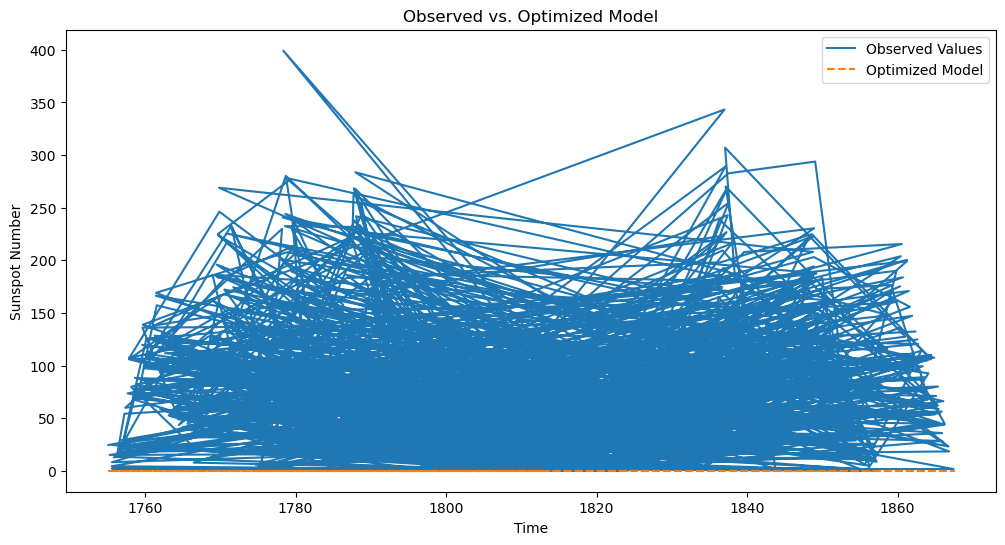

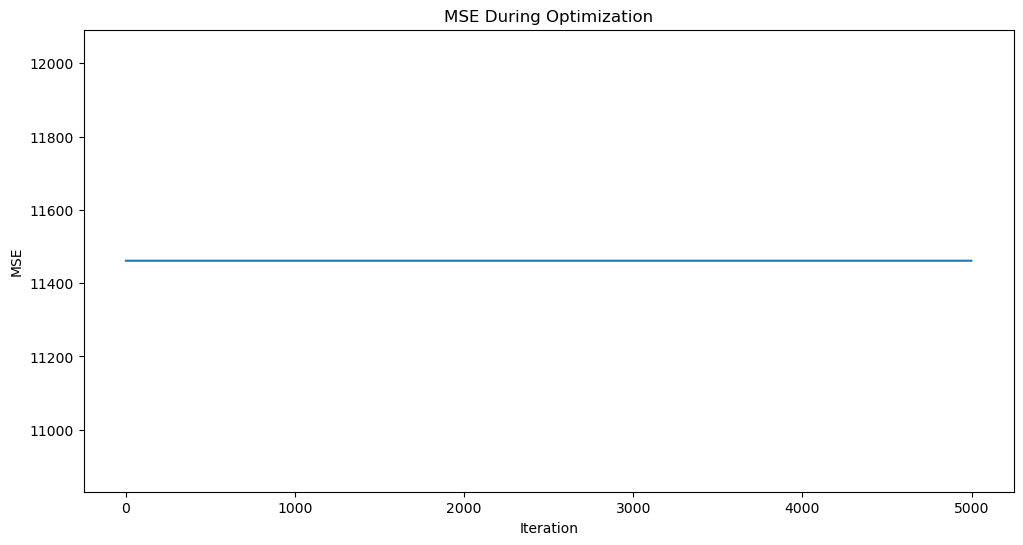

In [12]:
# Plot observed vs. optimized model
plt.figure(figsize=(12, 6))
plt.plot(time_points, observed_values, label="Observed Values")
plt.plot(time_points, optimized_values, label="Optimized Model", linestyle="--")
plt.legend()
plt.title("Observed vs. Optimized Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.show()

# Plot parameter convergence
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(optimized_params)), [mse(p, time_points, observed_values) for p in optimized_params])
plt.title("MSE During Optimization")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

In [ ]:

# code aus dem kurs funltioniert nicht
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, optimized_params, time_points, observed_values)
plt.plot(mse_curve)
plt.show(block=False)

# print mse for the last state
mse(mse_curve[-1])

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:

# Check the final state of the tuning process.
# It should already work pretty well!
plt.figure(figsize=(10, 6))

# Plot x (prey) and y (predator) over time
plt.scatter(t, x_data, label="Prey (x)", color="blue", s=20)
plt.scatter(t, y_data, label="Predator (y)", color="red", s=20)

plt.plot(t, x_test, label="Prey (x)", color="blue", linewidth=2)
plt.plot(t, y_test, label="Predator (y)", color="red", linewidth=2)

# Add titles and labels
plt.title("Evolution of Prey and Predator Populations", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Population", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show(block=False)

### Run optimization

In [ ]:
# Initial condition
params_from_tuning = outSA[-1]

n_chains = 5
params0noisy = np.abs(params_from_tuning + np.random.normal(0, 0.001, (n_chains, 4)))  # abs avoids negative numbers

T0 = 1
sigma = 5e-8

n_iter = 1000
burn_in = 500


results = np.empty((int(n_chains*(n_iter - burn_in)), 4))  # allocate array to store results
results.shape



for ix in range(n_chains):
    
    opt = simulated_annealing_optim(params0noisy[ix], T0, sigma, mse, burn_in = burn_in, n_iter = n_iter)
    start_idx = ix * opt.shape[0]
    end_idx = start_idx + opt.shape[0]
    # Write the `opt` output directly into the allocated array
    results[start_idx:end_idx, :] = opt

### Final Fit

In [ ]:
n_params = params0noisy.shape[1]
n_params

In [ ]:
center_of_mass = np.zeros(n_params)
for ix in range(n_params):
    counts, bin_edges = np.histogram(results[:,ix], bins=20)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Calculate the center of mass
    # Weights are the counts of each bin
    center_of_mass[ix] = np.sum(bin_centers * counts) / np.sum(counts)

In [ ]:
center_of_mass

In [ ]:

final_x, final_y = generate_data(t, z0, center_of_mass)

plt.figure(figsize=(10, 6))

# Plot x (prey) and y (predator) over time
plt.scatter(t, x_data, label="Prey (x)", color="blue", s=20)
plt.scatter(t, y_data, label="Predator (y)", color="red", s=20)
plt.plot(t, final_x, label="Prey (x)", color="blue", linewidth=2)
plt.plot(t, final_y, label="Predator (y)", color="red", linewidth=2)

# Add titles and labels
plt.title("Evolution of Prey and Predator Populations", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Population", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show(block=False)

In [ ]:
 Give quantitative results (wall time)

# Parallel programming techniques

Discuss parallelisation opportunities in the problem

Explain the parallelisation techniques that you have used (e.g., data partitioning, 
multiprocessing, MPI, …)



Explain why you chose such approach(es)


Highlight any challenges faced during parallelisation

# Results and Performance Metrics

 Compare performances of the initial (non-parallel) solution and the parallelised version 
• Give quantitative results (wall time)